In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import calendar 

In [3]:
data = {
    'clay': [20.5],
    'depth': [90.0],
    'iom': [2.25],
    'nsteps': [132]
}

head = pd.DataFrame(data)
head.to_csv('headSimulated.csv', index=False)

print(head)

   clay  depth   iom  nsteps
0  20.5   90.0  2.25     132


Se simularán datos del 2011 al 2020

1. Temperatura (Tmp): Simularemos las temperaturas mensuales basadas en promedios históricos, con una variación aleatoria para reflejar condiciones meteorológicas normales.
2. Precipitación (Rain): Las precipitaciones también se basarán en promedios mensuales, con fluctuaciones para simular eventos de lluvia más o menos intensos.
3. Evaporación (Evap): La evaporación será estimada en función de la temperatura y precipitación.
4. Carbono Inorgánico (C_inp) y Fertilizante Orgánico (FYM): Estos se asignarán en ciertos meses del año, reflejando las prácticas agrícolas de fertilización y manejo del suelo.
5. Prácticas de Cultivo (PC): Variará a lo largo del año dependiendo de las actividades de manejo estacional.
6. Relación de Masa de Partículas Descompuestas a Partículas de Roca (DPM_RPM): Este será un valor constante que refleja la calidad general del suelo en la región.

In [4]:
# Configuración de las simulaciones
years = range(2010, 2021)
months = range(1, 13)
strategy = 'intensive'
data = []

Preprocesamiento necesario del df con datos meteorológicos históricos de La Rioja

In [5]:
dfLR = pd.read_excel('datosLaRioja.xlsx')
# Diccionario de nombres de meses en inglés y español
# Diccionario de nombres de meses en español y inglés
meses_espanol_ingles = {
    'Enero': 'January',
    'Febrero': 'February',
    'Marzo': 'March',
    'Abril': 'April',
    'Mayo': 'May',
    'Junio': 'June',
    'Julio': 'July',
    'Agosto': 'August',
    'Septiembre': 'September',
    'Octubre': 'October',
    'Noviembre': 'November',
    'Diciembre': 'December'
}

# Aplicar el diccionario para cambiar los nombres de los meses
dfLR['mes'] = dfLR['mes'].map(meses_espanol_ingles)


Para el cálculo de la variable evaporación

In [6]:
def calculate_evap(year, month, df):
    T = df[(df['año'] == year) & (df['mes'] == month)]['TempMedia'].values[0] #Temperatura media mensual
    Hr = df[(dfLR['año'] == year) & (df['mes'] == month)]['Hr'].values[0]  # Humedad relativa media mensual en porcentaje
    Rg = df[(df['año'] == year) & (df['mes'] == month)]['Rg'].values[0]  # Radiación global acumulada en MJ/m²

    alpha = 0.0023
    Kp = 0.7
    
    
    Eo = alpha *(T + 17.8)*(Rg)*(1-Hr/100)
    E = Kp * Eo
    
    return E

Para el cálculo del carbono moderno

In [7]:
def simulate_modern_carbon(year, month, strategy, temp, rain):
    
    if strategy == 'traditional':
        params = {
            'base_modern_carbon': 90,  # Valor base de carbono moderno
            'decrease_factor': 0.04    # Factor de disminución anual del carbono moderno
        }
    elif strategy == 'organic':
        params = {
            'base_modern_carbon': 110,  # Valor base de carbono moderno
            'decrease_factor': 0.03     # Factor de disminución anual del carbono moderno
        }
    elif strategy == 'intensive':
        params = {
            'base_modern_carbon': 100,  # Valor base de carbono moderno
            'decrease_factor': 0.05     # Factor de disminución anual del carbono moderno
        }
    else:
        params = {
            'base_modern_carbon': 100,  # Valor base de carbono moderno
            'decrease_factor': 0.05     # Factor de disminución anual del carbono moderno
        }

    # Cálculo del impacto climático
    temp_impact = 0.1 if temp > 25 else 0.05
    rain_impact = 0.03 if rain < 20 else 0.05
    combined_climate_impact = temp_impact + rain_impact

    # Ajuste por año
    year_effect = (year - 1950) * params['decrease_factor']
    # Ajuste por impacto climático
    climate_effect = combined_climate_impact * month  # Ejemplo simplificado
    modern = params['base_modern_carbon'] - year_effect - climate_effect
    return modern

Para el calculo del carbono inorgánico 

In [8]:


def simulate_c_inp(month, strategy):
    winter_months = ['January', 'February', 'March', 'November', 'December']
    # Definir rangos básicos de entrada de carbono
    low_input = np.random.uniform(0.05, 0.15)
    high_input = np.random.uniform(0.15, 0.25)
    
    if strategy == 'organic':
        # Estrategia orgánica puede incluir más restos vegetales y compost
        if month in winter_months:
            return low_input + 0.05
        else:
            return high_input + 0.05
    elif strategy == 'intensive':
        # Estrategia intensiva puede incluir podas adicionales y más fertilización
        if month in winter_months:
            return low_input + 0.1
        else:
            return high_input + 0.1
    else:
        # Estrategia por tradicional
        if month in winter_months:
            return low_input
        else:
            return high_input

Para el calculo de FYM

In [9]:
def simulate_fym(month, strategy):
    low_fym = np.random.uniform(0.0, 0.1)
    high_fym = np.random.uniform(0.1, 0.2)
    
    if strategy == 'organic':
        if month in ['February', 'May', 'November']:
            return high_fym
        else:
            return low_fym
    elif strategy == 'intensive':
        if month in ['January', 'March', 'June', 'September']:
            return high_fym
        else:
            return low_fym
    else:
        if month in ['February', 'November']:
            return high_fym
        else:
            return low_fym

Cáluclo de PC


In [10]:
def simulate_pc(month, strategy):
   
    if strategy == 'traditional':
        # Asume que el suelo está mayormente cubierto, excepto durante el invierno y la preparación del suelo
        if month in ['January', 'February', 'March', 'December']:
            return 0
        else:
            return 1
    elif strategy == 'organic':
        # Estrategia orgánica generalmente mantiene el suelo cubierto durante más tiempo
        if month in ['January', 'February']:
            return 0
        else:
            return 1
    elif strategy == 'intensive':
        # Estrategia intensiva puede tener el suelo desnudo durante la preparación y en verano durante el manejo intensivo
        if month in ['January', 'February', 'July', 'August', 'September']:
            return 0
        else:
            return 1
    else:
        # Por defecto, similar a la estrategia tradicional
        if month in ['January', 'February', 'March', 'December']:
            return 0
        else:
            return 1

Calculo relación

In [11]:
def simulate_dpm_rpm(month, strategy):

    if strategy == 'traditional':
        # Para estrategias tradicionales, se usan valores estándar basados en estudios
        if month in ['April', 'May', 'June', 'July']:
            return 1.44  # Meses de alta actividad biológica
        else:
            return 0.67  # Meses de menor actividad biológica
    elif strategy == 'organic':
        # La estrategia orgánica podría tener una mayor proporción de DPM debido a la adición constante de materia orgánica
        if month in ['April', 'May', 'June', 'July']:
            return 1.5  # Ligeramente mayor para reflejar la constante adición de materia orgánica
        else:
            return 0.75  # Mayor incluso en meses de menor actividad
    elif strategy == 'intensive':
        # Estrategia intensiva puede tener una relación más alta debido a la intensa adición de residuos vegetales
        if month in ['April', 'May', 'June', 'July']:
            return 1.6  # Mayor proporción de DPM en meses de alta actividad
        else:
            return 0.8  # Mayor proporción de DPM incluso en meses de menor actividad
    else:
        # Valor por defecto basado en prácticas agrícolas comunes
        if month in ['April', 'May', 'June', 'July']:
            return 1.44
        else:
            return 0.67

In [12]:
for year in years:
    for month in months:
        
        #SIMULACIÓN TEMPERATURA Y PRECIPITACIÓN
        month_name = calendar.month_name[month]
        temp = dfLR[(dfLR['año'] == year) & (dfLR['mes'] == month_name)]['TempMedia'].values[0]
        rain = dfLR[(dfLR['año'] == year) & (dfLR['mes'] == month_name)]['Precmm'].values[0]

        #SIMULACIÓN EVAPORACION
        evap = calculate_evap(year, month_name, dfLR)
        
        
        #SIMULACIÓN CARBONO MODERNO

        modern = simulate_modern_carbon(year, month, strategy, temp, rain)

        # SIMULACIÓN DE LAS NUEVAS VARIABLES (c_inp. fym, pc, dpm_rpm)
        c_inp = simulate_c_inp(month_name, strategy)
        fym = simulate_fym(month_name, strategy)
        pc = simulate_pc(month_name, strategy)
        dpm_rpm = simulate_dpm_rpm(month_name, strategy)

        # Compilar los datos
        data.append([year, month, modern, temp, rain, evap, c_inp, fym, pc, dpm_rpm])





Para simular la variable 'modern' de manera realista, asumiendo que estamos trabajando con un caso de uso de viñedos en La Rioja y considerando las prácticas agrícolas y las condiciones climáticas de la región, necesitaríamos hacer algunas suposiciones basadas en el conocimiento del manejo de viñedos:

1. Los viñedos pueden tener una adición de carbono más estable debido a prácticas consistentes de manejo del suelo y poda.
2. Podría haber una acumulación de carbono a lo largo del tiempo debido a la materia orgánica que permanece en el suelo.
3. Los eventos de poda, cosecha y otras prácticas pueden influir en la variabilidad interanual y estacional.

=> Deberías ajustar modern_increase y modern_monthly_variation según las prácticas agrícolas y la información climática de los viñedos de La Rioja que tengas disponibles.

In [13]:
df = pd.DataFrame(data, columns=["year", "month", "modern", "Tmp", "Rain", "Evap", "C_inp", "FYM", "PC", "DPM_RPM"])

# Convertir las columnas FYM y PC a tipo de dato entero (int)
df['FYM'] = df['FYM'].astype(int)
df['PC'] = df['PC'].astype(int)

# Mostrar las primeras filas del DataFrame generado
df

,year,month,modern,Tmp,Rain,Evap,C_inp,FYM,PC,DPM_RPM
0,2010,1,96.90,4.197419,44.420,1.124157,0.179525,0,0,0.8
1,2010,2,96.84,4.975826,18.710,1.791464,0.202388,0,0,0.8
2,2010,3,96.76,7.931042,17.720,5.376506,0.200146,0,1,0.8
3,2010,4,96.60,12.667600,22.380,9.736884,0.306149,0,1,1.6
4,2010,5,96.50,13.292031,55.600,9.454092,0.332607,0,1,1.6
...,...,...,...,...,...,...,...,...,...,...
127,2020,8,95.70,21.789395,32.926,16.394469,0.302905,0,0,0.8
128,2020,9,95.60,18.804412,28.078,12.815580,0.258618,0,0,0.8
129,2020,10,95.50,12.888694,30.704,4.585105,0.329486,0,1,0.8
130,2020,11,95.40,9.865588,31.310,1.352734,0.170204,0,1,0.8


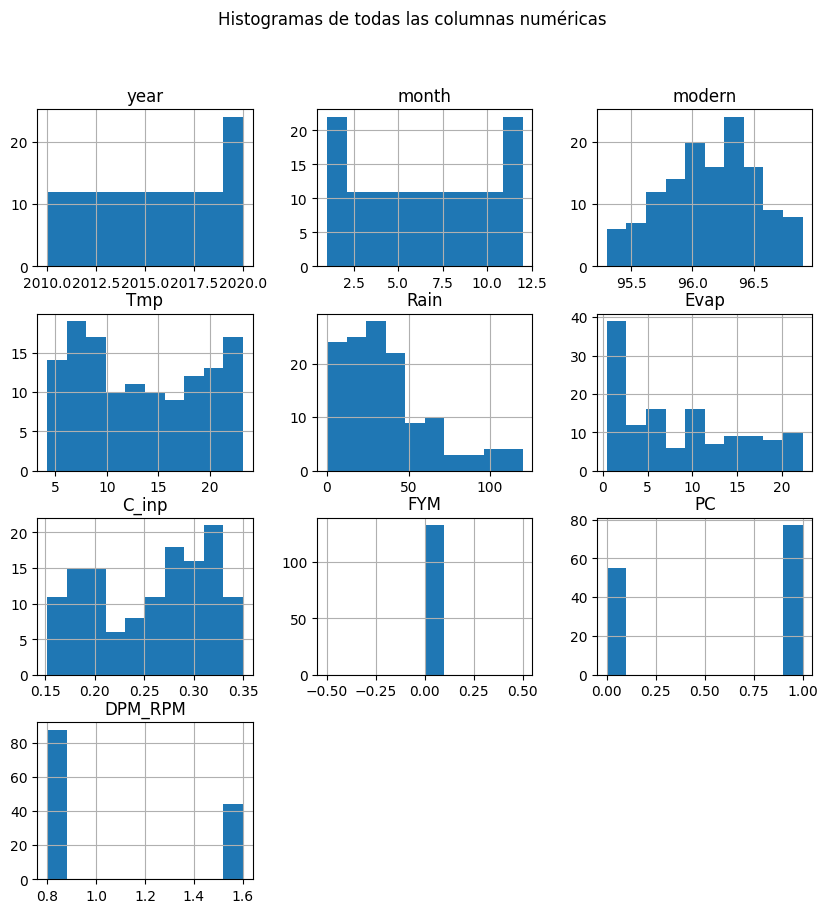

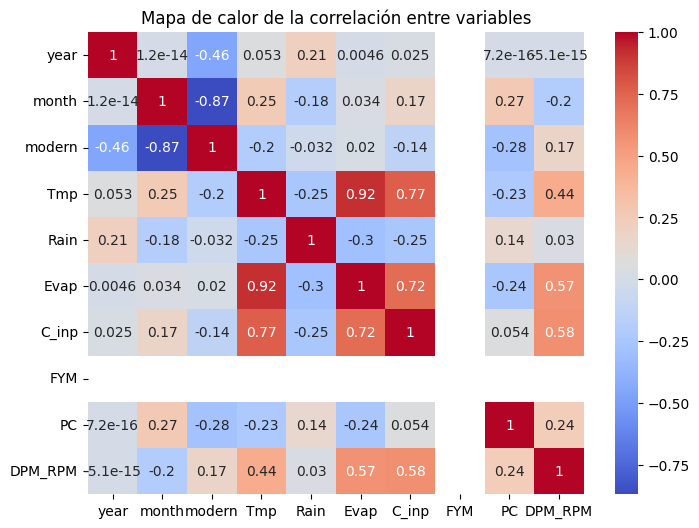

In [14]:

# Estadísticas descriptivas
descripcion = df.describe()

# Histogramas para todas las columnas numéricas
df.hist(figsize=(10, 10))
plt.suptitle('Histogramas de todas las columnas numéricas')
plt.show()

# Mapa de calor de las correlaciones
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Mapa de calor de la correlación entre variables')
plt.show()

'''
# Boxplots para visualizar distribuciones y detectar valores atípicos
for column in df.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure()
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot de {column}')
    plt.show()

# Modelo de regresión (ejemplo simple)
y = df['Variable_Dependiente']
X = df[['Variable_Independiente1', 'Variable_Independiente2']]
X = sm.add_constant(X)  # Añadir constante
model = sm.OLS(y, X).fit()
print(model.summary())
''' 

# Guardar el informe de descripción a un archivo de texto
with open('informe_descriptivo.txt', 'w') as f:
    f.write(descripcion.to_string())

- Fuerte correlación negativa entre Tmp  y Evap ->  temperaturas más altas suelen incrementar la tasa de evaporación.
- Correlación negatia entre Temp y Rain -> periodos cálidos asociados con menos lluvia y viceversa 


In [14]:
df

,year,month,modern,Tmp,Rain,Evap,C_inp,FYM,PC,DPM_RPM
0,2010,1,96.90,4.197419,44.420,1.124157,6.764052,10,59,2.620447
1,2010,2,96.84,4.975826,18.710,1.791464,6.867558,8,59,1.424321
2,2010,3,96.76,7.931042,17.720,5.376506,4.896781,10,51,2.227137
3,2010,4,96.60,12.667600,22.380,9.736884,5.761038,10,54,1.666837
4,2010,5,96.50,13.292031,55.600,9.454092,6.494079,9,53,1.072952
...,...,...,...,...,...,...,...,...,...,...
127,2020,8,95.70,21.789395,32.926,16.394469,3.820842,12,58,2.187482
128,2020,9,95.60,18.804412,28.078,12.815580,3.667788,6,43,1.587909
129,2020,10,95.50,12.888694,30.704,4.585105,5.498690,12,52,2.371334
130,2020,11,95.40,9.865588,31.310,1.352734,4.777394,8,33,1.055514


In [15]:
df.to_csv('simulatedData_intensive.csv', index=False)

print("DataFrame guardado como CSV exitosamente.")

DataFrame guardado como CSV exitosamente.
